# Tarea 2. Ejercicio 2.

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn import metrics
from pylab import*
import seaborn as sns
import numpy as np
from sklearn.model_selection import (GridSearchCV, cross_val_score,
                                                 RandomizedSearchCV,
                                                 cross_validate,
                                                 StratifiedKFold)
from sklearn.tree import plot_tree

In [2]:
DF = pd.read_excel('Base.xlsx',index_col=0)
DF.head()

,Dar_Credito,comp_interno1,comp_externo1,comp_externo2,comp_externo3,comp_externo4,comp_mixto1,inversion,comp_interno2,comp_interno3,comp_interno4,categoria1,categoria2,categoria3
0,1,0.000000,260.869565,25.854639,56.0,-230.0,0.33522,0.000000,b'0',11,58,2,9,156
1,1,0.000000,40.579710,2.872738,62.0,-230.0,0.33334,0.041039,b'1',28,45,1,4,173
2,1,0.000000,119.000000,-230.000000,0.0,0.0,0.29186,0.000000,b'1',25,45,1,9,170
3,1,0.000000,349.275362,34.616490,94.0,-230.0,0.29112,0.000000,b'1',14,59,3,3,159
4,1,2026.342452,276.811594,27.434645,125.0,-230.0,0.27318,77.422135,b'1',1,67,2,9,146


In [3]:
train, test = train_test_split(DF, test_size = 0.30, random_state = 100) 

In [4]:
train_x = train.iloc[:,1:]
train_y = train.iloc[:,0]
test_x = test.iloc[:,1:]
test_y = test.iloc[:,0]

# Recordemos que el tarea 1 ejercicio 1 ya se le dio un tratamiento a los datos faltantes (NA's).
### Y debido al análisis que se hizo en el ejercicio anterior, retiraremos ciertas variables que no aportan la información deseada o es redundante.

In [5]:
train_x = train_x.drop(["comp_externo2","categoria3","comp_interno1","comp_externo3","comp_mixto1","comp_interno2","categoria2"],axis=1)
test_x = test_x.drop(["comp_externo2","categoria3","comp_interno1","comp_externo3","comp_mixto1","comp_interno2","categoria2"],axis=1)

In [6]:
def performance_evaluation_report(model, X_test, y_test, show_plot=False, labels=None, show_pr_curve=False):
    '''
    Function for creating a performance report of a classification model.
    
    Parameters
    ----------
    model : scikit-learn estimator
        A fitted estimator for classification problems.
    X_test : pd.DataFrame
        DataFrame with features matching y_test
    y_test : array/pd.Series
        Target of a classification problem.
    show_plot : bool
        Flag whether to show the plot
    labels : list
        List with the class names.
    show_pr_curve : bool
        Flag whether to also show the PR-curve. For this to take effect, 
        show_plot must be True.
        
    Return
    ------
    stats : pd.Series
        A series with the most important evaluation metrics
    '''
    y_pred = model.predict(X_test)
    y_pred_prob = model.predict_proba(X_test)[:, 1]

    cm = metrics.confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = cm.ravel()

    fpr, tpr, threshold = metrics.roc_curve(y_test, y_pred_prob)
    roc_auc = metrics.auc(fpr, tpr)

    precision, recall, thresholds = metrics.precision_recall_curve(
        y_test, y_pred_prob)
    pr_auc = metrics.auc(recall, precision)

    if show_plot:

        if labels is None:
            labels = ['Negative', 'Positive']

        N_SUBPLOTS = 3 if show_pr_curve else 2
        PLOT_WIDTH = 15 if show_pr_curve else 12
        PLOT_HEIGHT = 5 if show_pr_curve else 6

        fig, ax = plt.subplots(
            1, N_SUBPLOTS, figsize=(PLOT_WIDTH, PLOT_HEIGHT))
        fig.suptitle('Performance Evaluation', fontsize=16)

        sns.heatmap(cm, annot=True, fmt="d", linewidths=.5, cmap='BuGn_r', square=True, cbar=False, ax=ax[0],
                    annot_kws={"ha": 'center', "va": 'center'})
        ax[0].set(xlabel='Predicted label',
                  ylabel='Actual label', title='Confusion Matrix')
        ax[0].xaxis.set_ticklabels(labels)
        ax[0].yaxis.set_ticklabels(labels)

        ax[1].plot(fpr, tpr, 'b-', label=f'ROC-AUC = {roc_auc:.2f}')
        ax[1].set(xlabel='False Positive Rate',
                  ylabel='True Positive Rate', title='ROC Curve')
        ax[1].plot(fp/(fp+tn), tp/(tp+fn), 'ro',
                   markersize=8, label='Decision Point')
        ax[1].plot([0, 1], [0, 1], 'r--')
        ax[1].legend(loc='lower right')

        if show_pr_curve:

            ax[2].plot(recall, precision, label=f'PR-AUC = {pr_auc:.2f}')
            ax[2].set(xlabel='Recall', ylabel='Precision',
                      title='Precision-Recall Curve')
            ax[2].legend()
    stats = {'accuracy': metrics.accuracy_score(y_test, y_pred),
             'precision': metrics.precision_score(y_test, y_pred),
             'recall': metrics.recall_score(y_test, y_pred),
             'specificity': (tn / (tn + fp)),
             'f1_score': metrics.f1_score(y_test, y_pred),
             'cohens_kappa': metrics.cohen_kappa_score(y_test, y_pred),
             'roc_auc': roc_auc,
             'pr_auc': pr_auc}

    return stats

In [7]:
dec_tree = DecisionTreeClassifier(random_state=42)

In [8]:
tree_pipeline = Pipeline(steps=[('classifier', dec_tree)])

In [9]:
tree_pipeline.fit(train_x, train_y)

Pipeline(steps=[('classifier', DecisionTreeClassifier(random_state=42))])

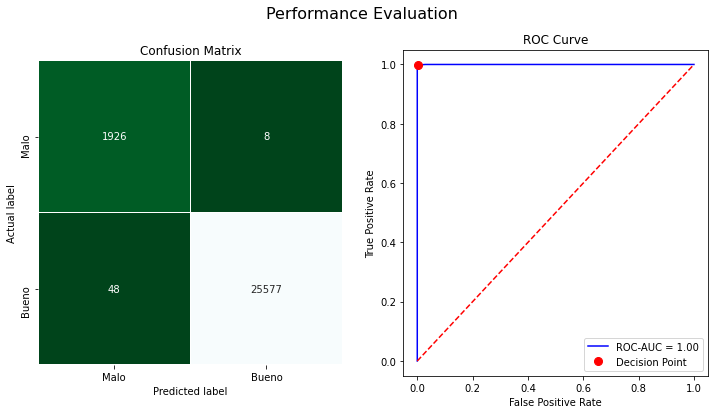

In [10]:
LABELS = ['Malo', 'Bueno']
tree_perf = performance_evaluation_report(tree_pipeline, train_x,train_y, labels=LABELS,show_plot=True)

### Aparentemente el árbol es muy bueno, demasiado para ser real. Veamos el comportamiento con la muestra test

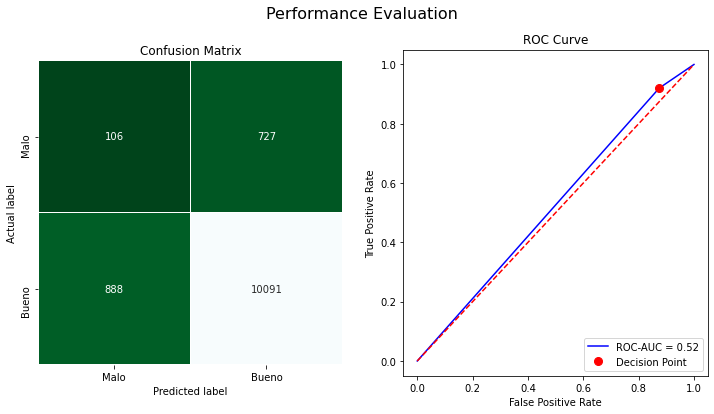

In [11]:
LABELS = ['Malo', 'Bueno']
tree_perf = performance_evaluation_report(tree_pipeline, test_x,test_y, labels=LABELS,show_plot=True)

### Lamentablemente con otro tipo de datos el modelo no es eficiente. Es decir, el árbol está sobrevalorando la información.

Ahora, mejoremos la información para obtener un mejor modelo

In [12]:
from sklearn.base import BaseEstimator, TransformerMixin

In [13]:
class OutlierRemover(BaseEstimator, TransformerMixin):
    def __init__(self, n_std=3):
        self.n_std = n_std
    
    def fit(self, X, y = None):
        if np.isnan(X).any(axis=None):
            raise ValueError('''There are missing values in the array! 
                                Please remove them.''')

        mean_vec = np.mean(X, axis=0)
        std_vec = np.std(X, axis=0)
        
        self.upper_band_ = mean_vec + self.n_std * std_vec
        self.lower_band_ = mean_vec - self.n_std * std_vec
        self.n_features_ = len(self.upper_band_)
        
        return self 
    
    def transform(self, X, y = None):
        X_copy = pd.DataFrame(X.copy())
        
        upper_band = np.repeat(
            self.upper_band_.reshape(self.n_features_, -1), 
            len(X_copy), 
            axis=1).transpose()
        lower_band = np.repeat(
            self.lower_band_.reshape(self.n_features_, -1), 
            len(X_copy), 
            axis=1).transpose()
        
        X_copy[X_copy >= upper_band] = upper_band
        X_copy[X_copy <= lower_band] = lower_band
        
        return X_copy.values

In [14]:
num_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('outliers', OutlierRemover())])

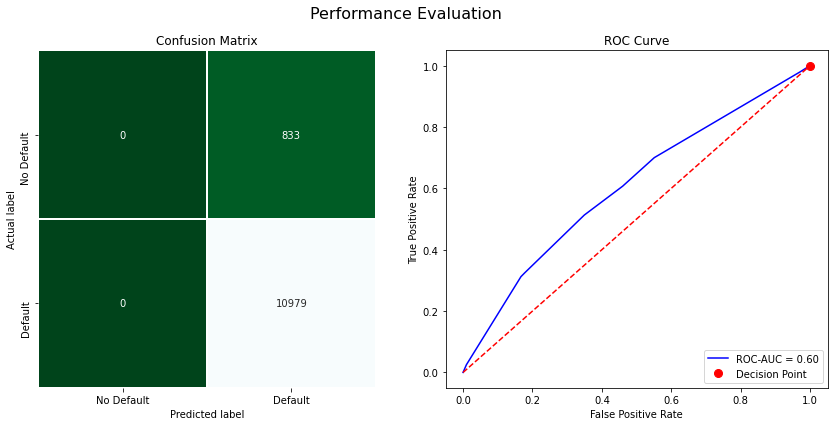

In [30]:
dec_tree = DecisionTreeClassifier(random_state=42, max_depth = 3, criterion = 'entropy', min_samples_leaf= 2)

tree_pipeline = Pipeline(steps=[('classifier', dec_tree)])

tree_pipeline.fit(train_x, train_y)

tree_perf = performance_evaluation_report(tree_pipeline, test_x, 
                                          test_y, labels=LABELS, 
                                          show_plot=True)

plt.tight_layout()
plt.show()

In [16]:
from sklearn.model_selection import (GridSearchCV, cross_val_score,
                                                 RandomizedSearchCV,
                                                 cross_validate,
                                                 StratifiedKFold)

In [17]:
k_fold = StratifiedKFold(5, shuffle=True, random_state=42)

In [18]:
cross_val_score(tree_pipeline, train_x, train_y, cv=k_fold)

array([0.85758345, 0.86429608, 0.86066763, 0.86520319, 0.86681183])

In [19]:
cross_validate(tree_pipeline, train_x, train_y, cv=k_fold,
                           scoring=['accuracy', 'precision', 'recall','roc_auc'])

{'fit_time': array([0.13991809, 0.20887661, 0.14691901, 0.11693144, 0.13290429]),
 'score_time': array([0.02097201, 0.03598022, 0.02698469, 0.02000785, 0.02398729]),
 'test_accuracy': array([0.85758345, 0.86429608, 0.86066763, 0.86520319, 0.86681183]),
 'test_precision': array([0.93158313, 0.93174196, 0.93130073, 0.93351801, 0.93295208]),
 'test_recall': array([0.91395122, 0.92156098, 0.91785366, 0.92058537, 0.92312195]),
 'test_roc_auc': array([0.51227579, 0.51357963, 0.51018365, 0.52743732, 0.52078554])}

In [20]:
param_grid = {'classifier__criterion': ['entropy', 'gini'],
               'classifier__max_depth': range(3, 11),
               'classifier__min_samples_leaf': range(2, 11)}

In [21]:
classifier_gs = GridSearchCV(tree_pipeline, param_grid,scoring='recall',cv=k_fold, n_jobs=-1, verbose=1)
classifier_gs.fit(train_x, train_y)

Fitting 5 folds for each of 144 candidates, totalling 720 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    8.6s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   14.8s
[Parallel(n_jobs=-1)]: Done 472 tasks      | elapsed:   26.9s
[Parallel(n_jobs=-1)]: Done 713 out of 720 | elapsed:   36.8s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done 720 out of 720 | elapsed:   37.0s finished


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('classifier',
                                        DecisionTreeClassifier(random_state=42))]),
             n_jobs=-1,
             param_grid={'classifier__criterion': ['entropy', 'gini'],
                         'classifier__max_depth': range(3, 11),
                         'classifier__min_samples_leaf': range(2, 11)},
             scoring='recall', verbose=1)

In [22]:
print(f'Best parameters: {classifier_gs.best_params_}') 
print(f'Recall (Training set): {classifier_gs.best_score_:.4f}') 
print(f'Recall (Test set): {metrics.recall_score(train_y, classifier_gs.predict(train_x)):.4f}')

Best parameters: {'classifier__criterion': 'entropy', 'classifier__max_depth': 3, 'classifier__min_samples_leaf': 2}
Recall (Training set): 1.0000
Recall (Test set): 1.0000


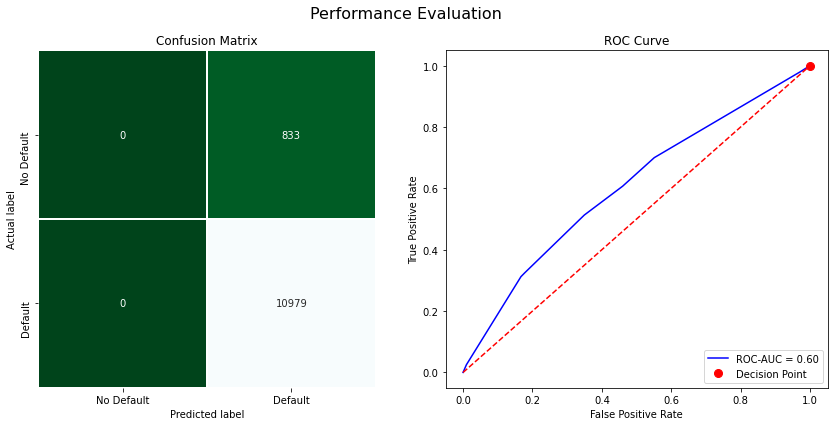

In [23]:
LABELS = ['No Default', 'Default']
tree_gs_perf = performance_evaluation_report(classifier_gs, test_x, 
                                             test_y, labels=LABELS, 
                                             show_plot=True)

plt.tight_layout()
plt.show()

In [24]:
from sklearn.metrics import roc_auc_score, roc_curve, mean_squared_error, precision_recall_curve,  accuracy_score

In [25]:
train_scores, val_scores, leaves = {}, {}, {}
for max_depth in range(1, 26):
    print(max_depth, end=' ', flush=True)
    reg_tree = DecisionTreeClassifier(criterion='entropy',
                                          max_depth=max_depth,
                                          min_samples_leaf=10,
                                          random_state=42)
    tree_pipeline = Pipeline(steps=[('classifier', reg_tree)])
    train_scores[max_depth], val_scores[max_depth], leaves[max_depth] = [],[], []
    for train_idx, test_idx in k_fold.split(train_x,train_y):
        X_t, y_t,  = train_x.iloc[train_idx], train_y.iloc[train_idx]
        X_te, y_te = train_x.iloc[test_idx], train_y.iloc[test_idx]
        tree_pipeline.fit(X_t, y_t)
        train_pred = tree_pipeline.predict_proba(X=X_t)[:, 1]
        train_score = roc_auc_score(y_score=train_pred, y_true=y_t)
        train_scores[max_depth].append(train_score)

        test_pred = tree_pipeline.predict_proba(X=X_te)[:, 1]
        val_score = roc_auc_score(y_score=test_pred, y_true=y_te)
        val_scores[max_depth].append(val_score)  
        leaves[max_depth].append(max_depth)

1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 

In [26]:
clf_train_scores = pd.DataFrame(train_scores)
clf_valid_scores = pd.DataFrame(val_scores)
bd_leaves = pd.DataFrame(leaves)

In [27]:
roc_entrenamiento=[]
for c in clf_train_scores.columns:
    promedio_roc=mean(clf_train_scores[c])
    roc_entrenamiento.append(promedio_roc)
    
roc_validacion=[]
for c in clf_valid_scores.columns:
    promedio_roc=mean(clf_valid_scores[c])
    roc_validacion.append(promedio_roc)

prof=[]
for c in bd_leaves.columns:
    id_=mean(bd_leaves[c])
    prof.append(id_)

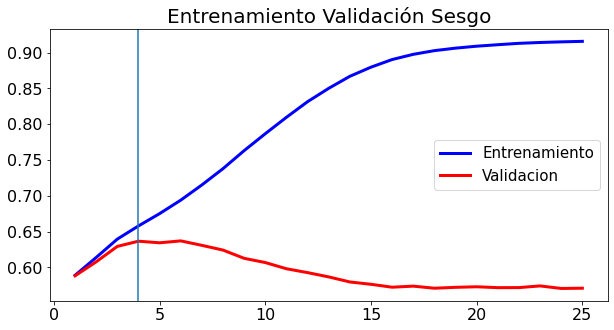

In [28]:
fig, ax = plt.subplots(figsize=(10,5))

ax.set_title("Entrenamiento Validación Sesgo",fontsize=20)
ax.plot(prof,roc_entrenamiento,color="blue",linewidth=3,label="Entrenamiento")
ax.plot(prof,roc_validacion,color="red",linewidth=3,label="Validacion")
xticks(fontsize=16)
yticks(fontsize=16)
axvline(4)
legend(fontsize=15)
show()

In [31]:
#Obtenemos el predict
y_pr_fit_test = dec_tree.predict_proba(test_x)
df_predicts_test = test_y.to_frame()
df_predicts_test['estimado'] = y_pr_fit_test[:,1]
#Construcción de Scorecard
from statsmodels.distributions.empirical_distribution import ECDF
from scipy.stats import ks_2samp
#KS
ecdf_malos_test = ECDF(df_predicts_test.loc[df_predicts_test.Dar_Credito==0.0,'estimado'])
ecdf_buenos_test= ECDF(df_predicts_test.loc[df_predicts_test.Dar_Credito==1.0,'estimado'])
grid_score_test = np.sort(df_predicts_test.estimado.unique())
prob_acum_buenos_test = ecdf_buenos_test(grid_score_test)
prob_acum_malos_test = ecdf_malos_test(grid_score_test)
abs_dif_test = np.abs(prob_acum_buenos_test-prob_acum_malos_test)
KS_test = np.max (abs_dif_test)
KS_test

0.1635485052933643